In [32]:

import os
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


# pvlib imports
import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib import irradiance


In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

import re

import copy

### TODOs: 

* Homogenize the test period, and get clear on the accuracy metrics

* Fix the physical bug (two are the same atm)


* RMSE Skill Implementation
    
    - What is the reference model?  == A linear regression on meteo on the aggregated data set


* Money Metric Function Implementation


* Physical Modelling: 
    
    - Implement the "Best-Case" and "Worst-Case" Scenario

* ML Modelling: 
   
    - Choose starting month randomly
    - Sample for all systems -> STD
    

### General Questions

* Use real irradiance data or historical forecasts?

In [151]:
def physical_profile(row, df_irr):
    latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"][
        "open_rack_glass_glass"
    ]

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        module_parameters={"pdc0": capacity, "gamma_pdc": -0.004},
        inverter_parameters={"pdc0": capacity},
        temperature_model_parameters=temperature_model_parameters,
    )

    mc = ModelChain(
        pvwatts_system, location, aoi_model="physical", spectral_model="no_loss" #these are my model chain assumptions
    )
    mc.run_model(df_irr)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"
    df_results.name = str(tilt) + ";" + str(azimuth)

    return df_results


def pv_day_filter(data, lat, lon, tilt, azimuth, timesteplen):

    site = Location(lat, lon)
    index = data.index
    times = pd.date_range(index[0], index[-1], freq=str(timesteplen) + "T")
    clearsky = site.get_clearsky(times)
    solar_position = site.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=clearsky["dni"],
        ghi=clearsky["ghi"],
        dhi=clearsky["dhi"],
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
    )

    day_index = POA_irradiance[POA_irradiance["poa_global"] > 0].index

    data_day_values = data.reindex(day_index).dropna()

    return data_day_values



def get_df_compare_physical(df_meta, df_power, df_irr, test_period_index):

    """
    df_irr must have columns ['ghi', 'dni', 'dhi']

    """

    df_compares = []
    timesteplen = int(test_period_index.freq.delta.seconds/60) # in minutes
    
    for system_id in df_meta.index:
        df_meta_data_id = df_meta.loc[system_id]
        lat, lon, tilt, azimuth, _ = df_meta_data_id.values
        
        df_irr = df_irr.reindex(test_period_index).dropna()
        df_physical_profile = physical_profile(df_meta_data_id, df_irr).to_frame("physical_profile").resample("15T").mean().fillna(method = "bfill", limit = 4) 
        df_physical_profile = pv_day_filter(df_physical_profile, lat, lon, tilt, azimuth, 15)

    
        df_power_id = df_power[[str(system_id)]].resample(str(timesteplen) + "T").mean()

        df_compare = pd.merge(df_power_id, df_physical_profile, left_index=True, right_index=True, how = "right").fillna(method = "bfill", limit= 4).dropna()
        df_physical_profile = pv_day_filter(df_compare, lat, lon, tilt, azimuth, timesteplen)
        df_compares.append(df_compare.reindex(test_period_index).dropna())

    return df_compares


def calc_accuracies_from_df_compares(df_compares:list, metrics:list, lat, lon, tilt, azimuth, timesteplen):

    """
    Inputs are a list of pd.DataFrames = [[df_predictions, df_ground_truth],[df_predictions, df_ground_truth], .... ] and a list of error metrics from sklearn.metrics

    Note that the mse will be reinterpreted as the nRMSE. This is because of the specific problem that has been analysis, i.e., the different capacities of pv systems. 

    Outputs are the error scores for each df in the dfs list for each error metric in a table that looks like:
    
    """


    metrics_names = [metric.__name__ for metric in metrics]
    df_acc = pd.DataFrame(columns = metrics_names, index = range(len(df_compares)))


    system_ids = []
    for i, df_compare in enumerate(df_compares):


        df_compare = pv_day_filter(df_compare, lat, lon, tilt, azimuth, timesteplen)
        system_ids.append(int(df_compare.columns[0]))

        for metric in metrics:
            metric_name = metric.__name__
            score = metric(df_compare.iloc[:,:1],df_compare.iloc[:,1:])
            if metric_name == "mean_squared_error":
                score = np.sqrt(score)
        
            df_acc.loc[i, metric_name] = score


    #transforming the mse into the rmse
    if "mean_squared_error" in metrics_names:

        df_acc["root_mean_squared_error"] = np.sqrt(df_acc["mean_squared_error"].astype("float32"))

        df_acc.drop(["mean_squared_error"], axis = 1, inplace=True)

    df_acc.index = system_ids

    return df_acc



def realistic_case_round(value:int, interval:int):

    """
    Rounding the tilt to 10th degrees.
    """
    rounded_value = round(value / interval) * interval
    
    return rounded_value



def make_df_plot_from_stats(stats_d):
    df_plot = pd.DataFrame(stats_d).T.round(4)
    df_plot.columns = ["mean", "std"]
    return df_plot


def metric_skill_score(df_accs_baseline:pd.DataFrame, df_accs_model:pd.DataFrame, scenario_name:str):
    """
    Calculated as follows
    1 - (score_model / score_reference) and then we average over all systems
    """

    
    df_skill_scores = (1 - df_accs_model.div(df_accs_baseline))
    mean = df_skill_scores.mean().to_frame("expected value_" + scenario_name)

    std = df_skill_scores.std().to_frame("standard deviation_" + scenario_name)

    out = pd.concat([mean, std], axis = 1)

    return out




def random_angle_init(
                        df_meta:pd.DataFrame, 
                        df_power:pd.DataFrame,
                        df_irr:pd.DataFrame,
                        df_acc_baseline:pd.DataFrame,
                        test_period_index: pd.date_range, 
                        lat, lon, tilt, azimuth, timesteplen,
                        error_metric_list:list,
                        tilt_bounds:tuple = (10,60), 
                        azimuth_bounds:tuple = (0,360),
                        scenario_name = "P3"
                        ):
    """
    Use for scenarios in which angles are guessed by the aggregator. They are drawn *iters*-times from a uniform distribution for all systems within the optionally specified bounds.
    Note: df_power and df_irr need to be in the global namespace of the file. 
    """

    df_meta_random = copy.deepcopy(df_meta)
    random_tilts = np.random.randint(tilt_bounds[0], tilt_bounds[1], (df_meta_random.shape[0]))
    random_azimuths = np.random.randint(azimuth_bounds[0], azimuth_bounds[1], (df_meta_random.shape[0]))
    df_meta_random["tilt"] = random_tilts
    df_meta_random["azimuth"] = random_azimuths
    df_meta_compare = get_df_compare_physical(df_meta_random, df_power, df_irr, test_period_index= test_period_index)
    df_meta_accs = calc_accuracies_from_df_compares(df_meta_compare, error_metric_list,lat, lon, tilt, azimuth, timesteplen)
    df_skill_score = metric_skill_score(df_acc_baseline, df_meta_accs, scenario_name)
    
    return df_skill_score



def acc_bar_plot(df_plot: pd.DataFrame):
    today = datetime.datetime.today()
    for i in range(df_plot.shape[0]):
        means = df_plot.iloc[i].filter(like = "exp").sort_index()
        stds = df_plot.iloc[i].filter(like = "dev").sort_index()
        
        # finding the scenario names for the x axis labels
        idx = means.index
        result = [re.findall(r'_(.*)', s)[0] for s in idx]
        
        
        fig, ax = plt.subplots(figsize = (12,8))
        ax.set_axisbelow(True)
        ax.grid(axis = "y")
        ax.bar(x = result, height = means, yerr =stds, capsize = 10)
        ax.set_ylim(-1,1)
        acc_score = means.name.replace("_", " ").title() + " Skill-Score"
        ax.set_ylabel(acc_score)
        fig.savefig(f"../../../Results/Plots/{acc_score}_{today}_persistence_ref.pdf")


In [35]:
def euro_cost_metric(gt, prediction, prices):
    pass

In [36]:
# Importing and merging the meta data; the optimized one is based on the tilt and azimuth inference script i wrote. 

df_meta = pd.read_csv("../../../Input_Data/Meta_Data_PV_Optimised.csv", index_col = 0)
df_meta_original = pd.read_csv("../../../Data/System/PV system information dataset TU WIEN.csv", sep = ";", index_col = 0)
df_meta_data = pd.merge(df_meta_original, df_meta, left_index=True, right_index=True)
df_meta_data["tilt"] = df_meta_data["tilt_finetuned"] 
df_meta_data["azimuth"] = df_meta_data["azimuth_finetuned"]
df_meta_data = df_meta_data.iloc[:,1:-2]



In [39]:
df_meteo_sol = pd.read_csv("../../../Input_Data/ghi_dni_dhi.csv", index_col=0, parse_dates=True).resample("15T").mean() # more complete than the other one
df_meteo_sol = df_meteo_sol[['ghi', 'dni', 'dhi']]
df_irr = df_meteo_sol 


In [26]:
# This is weather station irradiance data from Utrecht. There are some data points missing and the data is generally more volatile. As a result the data from solcast, which is based on satelite imagery, was selected. 

#df_meteo = pd.read_csv("/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Papers/Paper_2_Collaborative Forecasting/Data/Meteo/irradiance_data-2014_2017.csv", index_col=0, parse_dates=True)
#df_meteo = df_meteo[['GHI', 'DNI', 'DHI']]
#df_meteo.columns = ['ghi_', 'dni_', 'dhi_']
#df_meteo = df_meteo.resample("15T").mean()
#df_irr = df_meteo
#df_irr.index = df_irr.index.tz_localize(tz = None)


In [40]:
df_power = pd.read_csv("../../../Input_Data/PV_System_Power.csv", index_col=0, parse_dates=True).resample("15T").mean()

# For subsequent comparison we need to select only those timestamps which are present in both dataframes. 
df_irr = df_irr.reindex(df_power.index)
df_irr = df_irr.dropna()
df_power = df_power.reindex(df_irr.index).dropna()

### Major Design Choices and Initialisations


In [139]:

# Everything is in 15-minute temporal resolution
timesteplen = 15

# This list collects al skill scores for the various data scenarios
dfs_skill_score = []


# Metrics used for accuracy (error) comparison
error_metric_list = [mean_squared_error, mean_absolute_error]

# Time period for which all forecast error scores are evaluated.
test_period_index = pd.date_range("2015-02-15", "2015-03-15", freq="15T")

# Getting the average meta data from all systems
lat_mean, lon_mean, tilt_mean, azimuth_mean, cap_mean = df_meta_data.mean(axis = 0).values

design_params = lat_mean, lon_mean, tilt_mean, azimuth_mean, timesteplen

# Benchmarks:


## Single System View


### 1) 48-Persistence




In [44]:
timesteps_per_day = int(24*60/timesteplen)

In [73]:
df_compares_persistence = []
for col in df_power:
    df_sys = df_power[[col]].shift(timesteps_per_day*2)
    df_sys = df_sys.reindex(test_period_index).dropna()
    df_sys.columns = [col + "persistence_forecast"]
    df_compare_persistence = pd.merge(df_power[col], df_sys, left_index=True, right_index=True)
    df_compares_persistence.append(df_compare_persistence)

In [85]:
df_accs_persistence = calc_accuracies_from_df_compares(df_compares_persistence, error_metric_list, *design_params)



### 2) Linear Regression

In [ ]:

df_compares_lr = []
for col in df_power:
    df_sys = df_power[[col]]
    # [ghi, dni, dhi, power]
    df_baseline = pd.concat([df_irr, df_sys], axis = 1).reindex(pd.date_range(df_power.index[0], df_power.index[-1], freq= "15T"))
    train, test = df_baseline.drop(test_period_index, axis = 0).dropna(), df_baseline.loc[test_period_index].dropna()
    X_train, y_train = train.iloc[:,:3] , train.iloc[:,-1:]
    X_test, y_test = test.iloc[:,:3] , test.iloc[:,-1:]
    model_baseline = XGBRegressor()
    model_baseline.fit(X_train, y_train)
    y_test[col + "lr_forecast"] = model_baseline.predict(X_test)

    df_compares_lr.append(y_test)


In [96]:

df_accs_lr = calc_accuracies_from_df_compares(df_compares_lr, error_metric_list, *design_params)


The below code shows that it is not the same to first do the accuarcy calculation and then aggregate it as first aggregating forecasts and measurements and then carrying out the accuracy calculation.
This is because of the non-linear operations in the accuracy metrics (e.g., square root and square) 

In [99]:
list_forecasts = []
list_measurements = []

for df_compare in df_compares_lr:
    list_measurements.append(df_compare.iloc[:, :1])
    list_forecasts.append(df_compare.iloc[:, 1:])

df_forecast_lr = pd.concat(list_forecasts, axis = 1).sum(axis = 1)
df_measurements_lr = pd.concat(list_measurements, axis = 1).sum(axis = 1)

df_compares_dis_to_agg = [pd.concat([df_measurements_lr, df_forecast_lr], axis = 1)]

calc_accuracies_from_df_compares(df_compares_dis_to_agg, error_metric_list, *design_params)

## Aggregated View

It turns out that for a linear model it does not matter if we perform the forecast on the aggregated values or not.
For a non-linear model like the XGBoost Regression, however, it does matter, with the model on the aggregated data winning ever so slightly. 

### Linear Regression

In [101]:
# [ghi, dni, dhi, power]
df_baseline = pd.concat([df_irr, df_power.sum(axis=1)], axis = 1).reindex(pd.date_range(df_power.index[0], df_power.index[-1], freq= "15T"))
train, test = df_baseline.drop(test_period_index, axis = 0).dropna(), df_baseline.loc[test_period_index].dropna()
X_train, y_train = train.iloc[:,:3] , train.iloc[:,-1:]
X_test, y_test = test.iloc[:,:3] , test.iloc[:,-1:]
model_baseline = XGBRegressor()
model_baseline.fit(X_train, y_train)
y_test[col + "lr_forecast"] = model_baseline.predict(X_test)

df_compares_lr_agg = [y_test]

df_accs_lr_agg = calc_accuracies_from_df_compares(df_compares_lr_agg, error_metric_list, *design_params)

df_accs_lr_agg

/var/folders/35/267ql_w95qlgmrzwgprns44w0000gn/T/ipykernel_19184/3693049392.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,mean_absolute_error,root_mean_squared_error
0,4547.97229,82.276337


# Physical Modelling

## 1) P1-OMNI (Everything is known)

In [114]:
df_compares_best_case_physical = get_df_compare_physical(df_meta_data, df_power, df_irr, test_period_index)
df_accs_best = calc_accuracies_from_df_compares(df_compares_best_case_physical, error_metric_list, *design_params)


In [140]:
scenario_name = "P1"
dfs_skill_score.append(metric_skill_score(df_accs_persistence, df_accs_best, scenario_name))
print(dfs_skill_score)

[                         expected value_P1  standard deviation_P1
mean_absolute_error               0.573885               0.118397
root_mean_squared_error           0.318915               0.074985]


## 2) P2-REAL (Angle Estimation by the Installer, Exact Location)

In [116]:

# since we are making some major changes we need a deep copy
df_meta_data_realistic_case = copy.deepcopy(df_meta_data)
#modifying the tilt angle based on estimation
df_meta_data_realistic_case["tilt"] = df_meta_data_realistic_case["tilt"].apply(lambda x: realistic_case_round(x, 10))
df_meta_data_realistic_case["azimuth"] = df_meta_data_realistic_case["azimuth"].apply(lambda x: realistic_case_round(x, 45)) #modifying the azimuth angle based on estimation
df_compares_realistic_case_physical = get_df_compare_physical(df_meta_data_realistic_case, df_power, df_irr, test_period_index)
df_acc_real = calc_accuracies_from_df_compares(df_compares_realistic_case_physical, error_metric_list, *design_params)

In [141]:
scenario_name =  "P2"
dfs_skill_score.append(metric_skill_score(df_accs_persistence, df_acc_real,scenario_name))
pd.concat(dfs_skill_score, axis = 1)

,expected value_P1,standard deviation_P1,expected value_P2,standard deviation_P2
mean_absolute_error,0.573885,0.118397,0.549860,0.130099
root_mean_squared_error,0.318915,0.074985,0.305623,0.080841


,expected value_P1,standard deviation_P1,expected value_P2,standard deviation_P2
mean_absolute_error,0.573885,0.118397,0.549860,0.130099
root_mean_squared_error,0.318915,0.074985,0.305623,0.080841


## 3) P3-LOC Known Angles but average location of the area

In [119]:
scenario_name = "P3"
df_meta_data_p3 = df_meta_data.copy()
df_meta_data_p3[["latitude", "longitude"]] = lat_mean, lon_mean
df_compares_p3 = get_df_compare_physical(df_meta_data_p3, df_power, df_irr, test_period_index)
df_acc_p3 = calc_accuracies_from_df_compares(df_compares_p3, error_metric_list, *design_params)

In [153]:
df_acc_p3

,mean_absolute_error,root_mean_squared_error
151,132.31984,14.662829
152,266.326825,20.278292
154,20.475366,5.422798
175,28.264761,6.593544
188,91.270359,11.638494
192,298.466125,20.240402
194,29.910224,6.670310
195,33.843372,6.987374
207,99.627759,12.681293
223,184.120339,17.131374


In [142]:
scenario_name =  "P3"
dfs_skill_score.append(metric_skill_score(df_accs_persistence, df_acc_p3,scenario_name))
pd.concat(dfs_skill_score, axis = 1)

,expected value_P1,standard deviation_P1,expected value_P2,standard deviation_P2,expected value_P3,standard deviation_P3
mean_absolute_error,0.573885,0.118397,0.549860,0.130099,0.574297,0.118185
root_mean_squared_error,0.318915,0.074985,0.305623,0.080841,0.319021,0.074987


## 4) P4-CAP

In [122]:
df_meta_data_p4 = copy.deepcopy(df_meta_data)
df_meta_data_p4["estimated capacity"] = cap_mean
df_compares_p4 = get_df_compare_physical(df_meta_data_p4, df_power, df_irr, test_period_index)
df_acc_p4 = calc_accuracies_from_df_compares(df_compares_p4, error_metric_list, *design_params)



In [163]:
df_acc_p4.mean()

mean_absolute_error        368.380665
root_mean_squared_error     22.024227
dtype: float64

In [143]:
scenario_name = "P4"
dfs_skill_score.append(metric_skill_score(df_accs_persistence, df_acc_p4,scenario_name))
pd.concat(dfs_skill_score, axis = 1)



,expected value_P1,standard deviation_P1,expected value_P2,standard deviation_P2,expected value_P3,standard deviation_P3,expected value_P4,standard deviation_P4
mean_absolute_error,0.573885,0.118397,0.549860,0.130099,0.574297,0.118185,-0.922021,3.265201
root_mean_squared_error,0.318915,0.074985,0.305623,0.080841,0.319021,0.074987,-0.135631,0.763049


## 5) P5-UNK (Random Guessing of Angle, Average Locations and Capacity)

In [124]:

scenario_name = "P5"
it = 10

skill_scores_rand =  []
for i in range(it):
    df_meta_copy = copy.deepcopy(df_meta_data_realistic_case)

    df_meta_copy["latitude"] = lat_mean
    df_meta_copy["longitude"] = lon_mean
    df_meta_copy["estimated capacity"] = cap_mean

    df_skill_score = random_angle_init(df_meta_data, df_power, df_irr,df_accs_persistence, test_period_index, lat_mean, lon_mean, tilt_mean, azimuth_mean, timesteplen, error_metric_list)
    skill_scores_rand.append(df_skill_score)


In [144]:
scenario_name = "P5"
df_concated  = pd.concat(skill_scores_rand, axis = 1)
mean_of_expected = df_concated.filter(like = "expected").mean(axis=1).to_frame("expected value_" + scenario_name)
mean_of_std = df_concated.filter(like = "standard").mean(axis=1).to_frame("standard deviation_" + scenario_name)
dfs_skill_score.append(pd.concat([mean_of_expected, mean_of_std], axis =1))

In [145]:
df_plot = pd.concat(dfs_skill_score, axis = 1)

In [152]:
df_plot

,expected value_P1,standard deviation_P1,expected value_P2,standard deviation_P2,expected value_P3,standard deviation_P3,expected value_P4,standard deviation_P4,expected value_P5,standard deviation_P5
mean_absolute_error,0.573885,0.118397,0.549860,0.130099,0.574297,0.118185,-0.922021,3.265201,0.206794,0.269338
root_mean_squared_error,0.318915,0.074985,0.305623,0.080841,0.319021,0.074987,-0.135631,0.763049,0.092751,0.152732


## Plotting Results

In [145]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Papers/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting/notebooks'

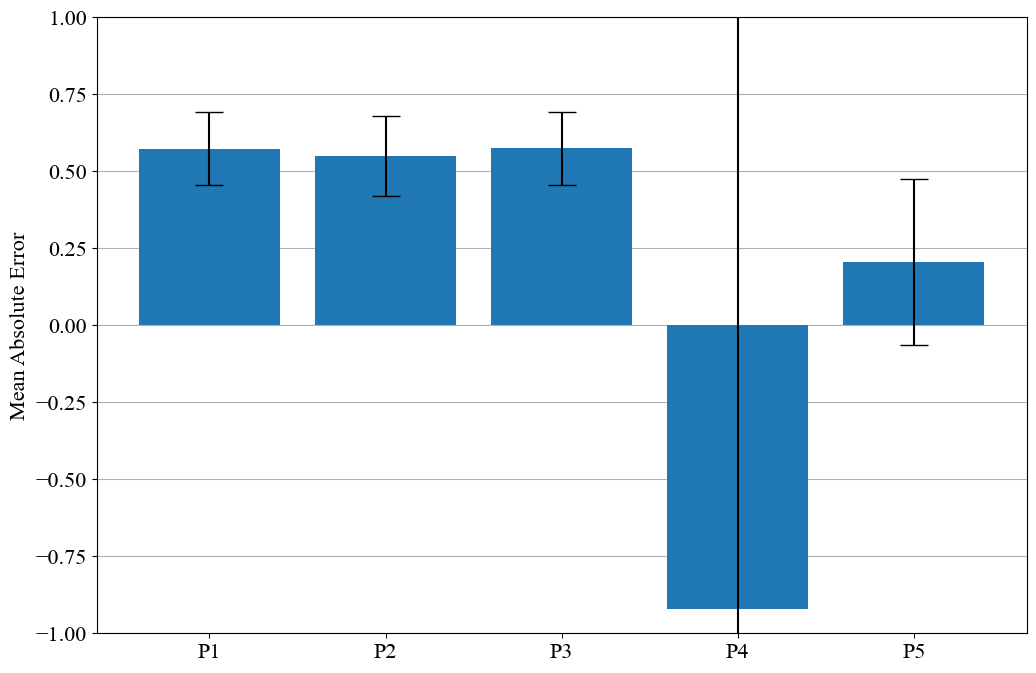

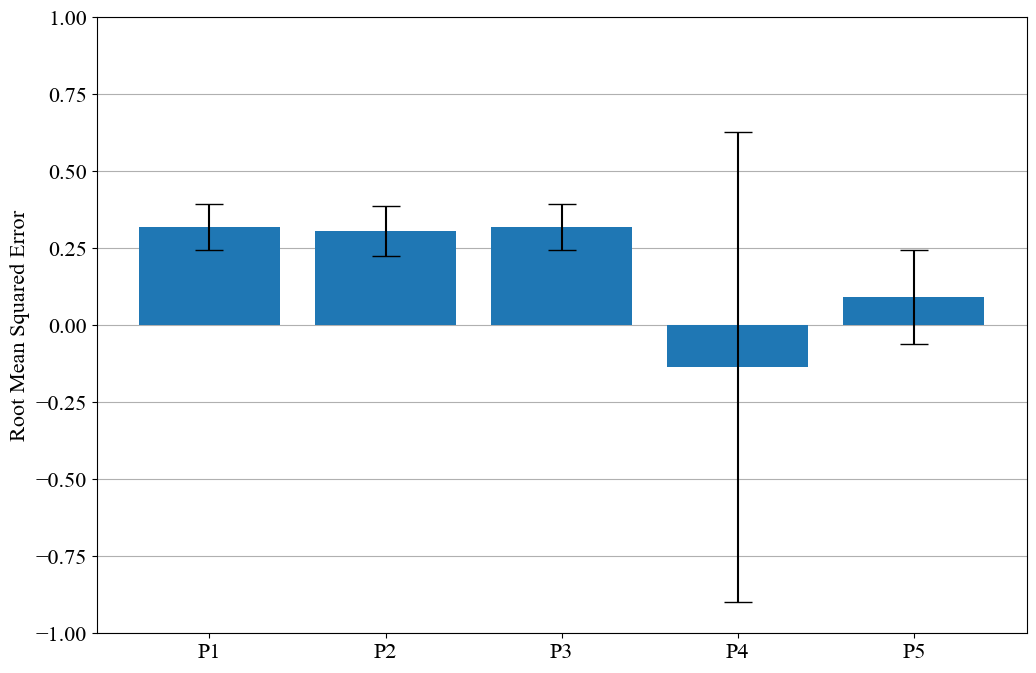

In [150]:
acc_bar_plot(df_plot)

# ML Modelling

In [214]:


def get_accuracies_per_month(df, model_type, metrics:list = None):

    accuracy_dictionary = {}

    start_date = df.index[0]
    test_begin = df.index[-1] - pd.Timedelta(days = 30)
    for month in range(1,12):
        train_end = start_date + pd.Timedelta(weeks = 4*month)

        assert train_end < test_begin, "Reduce the number of months, so a test period remains."
        train = df[start_date:train_end]

        test = df[test_begin:]


        scaler_ml_features = MinMaxScaler()
        scaler_ml_target = MinMaxScaler()

        X_train, y_train = scaler_ml_features.fit_transform(train.iloc[:,1:]), scaler_ml_target.fit_transform(train.iloc[:,:1])
        X_test, y_test = scaler_ml_features.transform(test.iloc[:,1:]), scaler_ml_target.transform(test.iloc[:,:1])


        model = model_type()
        model.fit(X = X_train, y = y_train)
        predictions = model.predict(X_test)

        gt_unscaled = scaler_ml_target.inverse_transform(y_test.reshape(-1,1))
        predictions_unscaled = scaler_ml_target.inverse_transform(predictions.reshape(-1,1))

        df_y_test = pd.DataFrame({"ground_truth":gt_unscaled.squeeze(), "predictions": predictions_unscaled.squeeze()}, index = test.index)

        rmse = mean_squared_error(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"], squared=False) / test.max()[0]
        r2 = r2_score(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"])

        accuracy_dictionary[month] = rmse, r2

    df_accuracy = pd.DataFrame(accuracy_dictionary, index = ["rmse", "r2"]).T

    return df_accuracy, df_y_test


In [215]:
rmse = []
r2 = []

for i in range(34):
    df_ml = pd.concat([df_power.iloc[:,i].to_frame("power_{}".format(i)), df_irr], axis = 1).dropna()
    x = get_accuracies_per_month(df_ml, LinearRegression)[0]
    rmse.append(x["rmse"])
    r2.append(x["r2"])





In [216]:
means_ml = pd.concat(rmse, axis = 1).mean(axis = 1)
std_ml = pd.concat(rmse, axis = 1).std(axis = 1)

df_stats_ml = pd.DataFrame({"mean": means_ml, "std": std_ml})

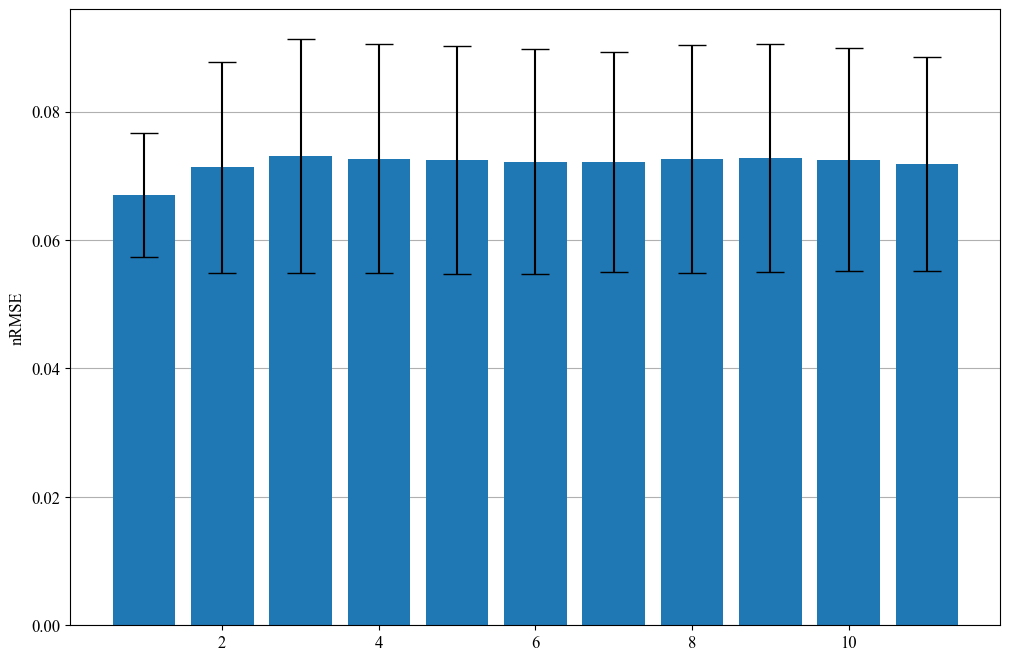

In [217]:




def acc_bar_plot(df_plot: pd.DataFrame, acc_name: str):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_axisbelow(True)
    ax.grid(axis = "y")
    ax.bar(x = df_plot.index, height = df_plot["mean"].values, yerr =df_plot["std"].values, capsize = 10)
    ax.set_ylabel(acc_name)


acc_bar_plot(df_stats_ml, "nRMSE")
